In [95]:
import numpy as np
#from scipy import stats
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin='lower')

from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import LogNorm

from functools import partial
from scarlet.display import AsinhMapping
#from photutils.psf import extract_stars
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
#from photutils import EPSFBuilder
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping
import sep
from functools import partial
import image_registration
import pandas as pd
import pandasql as ps
import pickle

In [2]:
channels = ['u','g','r','i','z']

In [3]:
def makeCatalog(img, lvl = 4):
    if np.size(img.shape) == 3:
        detect = img.mean(axis=0) # simple average for detection
    else:
        detect = img

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    if np.size(img.shape) == 3:
        bg_rms = np.array([sep.Background(band).globalrms for band in img])
    else:
        bg_rms =  sep.Background(detect).globalrms
    return catalog, bg_rms

In [4]:
def alignImages(hdulist):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
    alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    for image in range(1,len(hdulist)):
        im1 = hdulist[image]
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
        alignedHDU.append(im1_aligned_to_im2)

    return alignedHDU


In [5]:
def AlignOnly(imageName,refImageName,imageLimits='None',matchLimits='None'): # imageLimits = [miny,maxy,minx,maxx]
    image = fits.open(imageName)
    data = image[0].data.byteswap().newbyteorder()
    refImage = fits.open(refImageName)
    refData = refImage[0].data.byteswap().newbyteorder()
    #BG = sep.Background(data).globalback
    
    if matchLimits != 'None': # used to crop images to the same size
        data = data[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        refData = refData[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        
    print('data Shape',data.shape)
    print('refdata Shape',refData.shape)

    aligned = alignImages([refData,data])
    alignedData = aligned[1]
    data = alignedData
     
    return data

In [6]:
# for x in range(len(channels)):
#     aligned = AlignOnly(images[x],images[0],imageLimits=[minx,maxx,miny,maxy],matchLimits=[0,3970,0,1980])
#     #plt.imshow(aligned)
#     aData = fits.PrimaryHDU(aligned)
#     hdur = fits.HDUList([aData])
#     hdur.writeto('/home/mj1e16/scarlet/scarlet/data/globularCluster/Algined{}.fits'.format(channels[x]))

In [42]:
def makeImageData(imageName,psfName,filterName,refImageName,imageLimits='None',matchLimits='None'): # imageLimits = [miny,maxy,minx,maxx]
    image = fits.open(imageName)
    data = image[0].data.byteswap().newbyteorder()
    refImage = fits.open(refImageName)
    refData = refImage[0].data.byteswap().newbyteorder()
    BG = sep.Background(data).globalback
    
    if matchLimits != 'None': # used to crop images to the same size
        data = data[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        refData = refData[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        
    print('data Shape',data.shape)
    print('refdata Shape',refData.shape)

    aligned = alignImages([refData,data])
    alignedData = aligned[1]
    data = alignedData
    
    if imageLimits != 'None': 
        data = data[imageLimits[2]:imageLimits[3],imageLimits[0]:imageLimits[1]]
    
    wcs = WCS(image[0].header)
    data_BS = data - BG
    catalogue, bg_rms = makeCatalog(data_BS)
    weights = np.ones_like(data_BS) / (bg_rms**2)
    psf = fits.open(psfName)[0].data
    #psf = psf[None,:,:]
#    psf = scarlet.PSF(psf)
    return {'data':data_BS,'wcs':wcs,'backgorund':BG,'catalogue':catalogue,'weights':weights,'psf':psf,'filter':filterName}

In [8]:
def matchTables(array1,array2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.x < pandasTable2.xUpper
    AND pandasTable1.x > pandasTable2.xLower
    AND pandasTable1.y < pandasTable2.yUpper
    AND pandasTable1.y > pandasTable2.yLower
    '''
    
    ogDict = {'indexOG':range(len(array1)),'x':array1['x'],'y':array1['y']}
    pandasTable1 = pd.DataFrame(data=ogDict)
    
    xcoord = array2['x']
    ycoord = array2['y']
    flux = array2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'indexMatch':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [48]:
def antiMatchTables(array1,array2,tollerance=2.5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.x > pandasTable2.xUpper
    AND pandasTable1.x < pandasTable2.xLower
    AND pandasTable1.y > pandasTable2.yUpper
    AND pandasTable1.y < pandasTable2.yLower
    '''
    
    ogDict = {'indexOG':range(len(array1)),'x':array1['x'],'y':array1['y']}
    pandasTable1 = pd.DataFrame(data=ogDict)
    
    xcoord = array2['x']
    ycoord = array2['y']
    flux = array2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'indexMatch':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [56]:
images = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_041112_u_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040903_g_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_035740_r_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040445_i_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040655_z_50.fits']

psfImages = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/psfU.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/psfG.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/psfR.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/psfI.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/psfZ.fits']

channels = ['u','g','r','i','z']

miny = 1100
maxy = 1300

maxx = 400
minx = 200

refImage = images[0]

for x in range(len(channels)):
    Data = makeImageData(images[x],psfImages[x],channels[x],refImage,imageLimits=[minx,maxx,miny,maxy],matchLimits=[0,3970,0,1980])
    if x ==  0:
        imageList, catalogueList, weigthsList, psfList = [Data['data']], Data['catalogue'], [Data['weights']], [Data['psf']]
        print(Data['data'].shape)
        print(psfList[x].shape)
        print('clog',len(catalogueList))
    else:
        print(Data['data'].shape)
        imageList = np.append(imageList,[Data['data']],axis=0)
        #catalogueList.append(Data['catalogue'])
        catalogueList = np.concatenate((catalogueList,Data['catalogue']),axis=0)
        print('clog',len(catalogueList))
        weigthsList = np.append(weigthsList,[Data['weights']],axis=0)
        psfList = np.append(psfList,[Data['psf']],axis=0)

data Shape (1980, 3970)
refdata Shape (1980, 3970)
(200, 200)
(101, 101)
clog 39
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(200, 200)
clog 94
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(200, 200)
clog 154
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(200, 200)
clog 224
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(200, 200)
clog 301


In [10]:
psfs=scarlet.PSF(psfList)

In [57]:
len(catalogueList)

301

In [47]:
len(catalogueList[0])

39

In [58]:
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.9), shape=(None,101,101))

In [59]:
model_frame = scarlet.Frame(imageList.shape,
                          psfs=model_psf,
                          channels=channels)


In [60]:
observation = scarlet.Observation(
    imageList,
    psfs=psfs,
    weights=weigthsList,
    channels=channels).match(model_frame)


In [61]:
for x in range(len(catalogueList)):
    if x ==0:
        matchDF = catalogueList
    else:
        matchDF = matchTables(matchDF,catalogueList[x])

TypeError: 'numpy.float64' object is not iterable

In [15]:
matchArray = matchDF.to_records(index=False)

In [62]:
sources = []

for k,src in enumerate(catalogueList):
    print(k)
    sources.append(scarlet.ExtendedSource(model_frame,(src['y'],src['x']),observation))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [63]:
norm =  AsinhMapping(minimum=0, stretch=0.01, Q=1)

In [64]:
from matplotlib.colors import LogNorm

([], <a list of 0 Text xticklabel objects>)

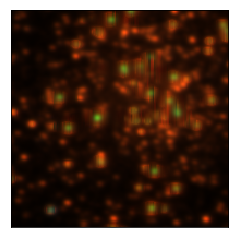

In [65]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(imageList)
plt.imshow(img_rgb,norm=LogNorm())
plt.yticks([])
plt.xticks([])
# Mark all of the sources from the detection cataog
# for k, src in enumerate(catalogueList[0]):
#     plt.text(src["x"], src["y"], str(k), color="red")



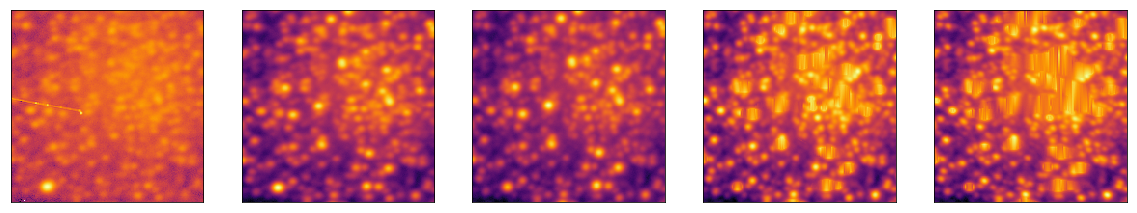

In [66]:
fig, ax = plt.subplots(1,5,figsize=(20,4))
for i,x in enumerate(imageList):
    ax[i].imshow(x,norm=LogNorm())
    ax[i].set_yticks([])
    ax[i].set_xticks([])

CPU times: user 14min 54s, sys: 2.06 s, total: 14min 56s
Wall time: 14min 6s
scarlet ran for 200 iterations to logL = -5161901765.926058


Text(0,0.5,'log-Likelihood')

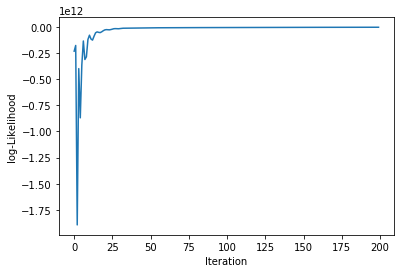

In [67]:
blend = scarlet.Blend(sources, observation)
%time blend.fit(200)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

In [71]:
model = blend.get_model()
model_ = observation.render(model)
residual = imageList-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual



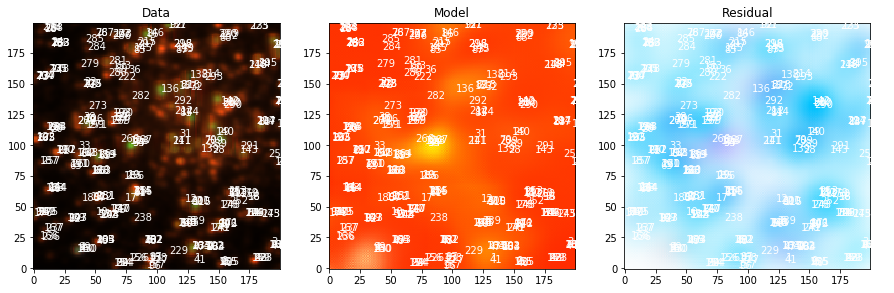

In [73]:
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend):
    y,x = component.center
    ax[0].text(x, y, k, color="w")
    ax[1].text(x, y, k, color="w")
    ax[2].text(x, y, k, color="w")
#plt.show()

In [94]:
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation,
                             show_rendered=True,
                             show_observed=True)
#plt.show()


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

In [77]:
# dataTestarino = np.load("./data/hsc_cosmos_35.npz")
# catalogTestarino = dataTestarino["catalog"]

In [93]:
# sourcesTestarino = []
# for k,src in enumerate(catalogTestarino):
#     if k == 0:
#         new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
#     elif k == 1:
#         new_source = scarlet.MultiComponentSource(model_frame, (src['y'], src['x']), observation)
#     else:
#         new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation)
#     sourcesTestarino.append(new_source)

In [22]:
print ("----------------- {}".format(channels))
fluxes = []
for k, src in enumerate(sources):
    fluxes.append(scarlet.measure.flux(src).tolist())
    #print ("Source {}, Fluxes: {}".format(k, scarlet.measure.flux(src)))

----------------- ['u', 'g', 'r', 'i', 'z']


In [23]:
fluxesNoZero = [x for x in fluxes if 0.0 not in x]
print(len(fluxesNoZero))

9


In [24]:
def createMag(flux,zpMag):
    mag = (-2.5*np.log10(flux)) + zpMag
    return mag

In [25]:
Magnitudes = createMag(fluxesNoZero,29.41)

In [26]:
u = Magnitudes[:,0]

In [27]:
r = Magnitudes[:,2]
g = Magnitudes[:,1]

In [28]:
gMinusR = g-r

Text(0.5,0,'g - r')

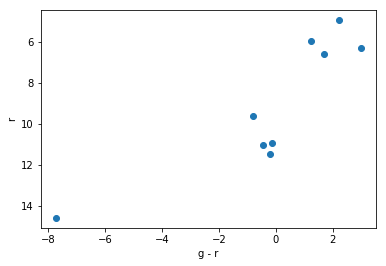

In [29]:
plt.plot(gMinusR,r,'o')
#plt.gca().invert_y_axis()
plt.gca().invert_yaxis()
plt.ylabel('r')
plt.xlabel('g - r')